In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import optax
import seaborn as sns

from blackjax import atess, tess

In [2]:
def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [3]:
logprob = lambda x1, x2: -0.5 * ((x1 - 2) ** 2 / 2 + (x2 + 1) ** 2 / 0.5)
logprob_fn = lambda x: logprob(**x)
num_batch = 10
batch_size = 128

n_warm = 10
n_iter = 10000

In [4]:
init, kernel = tess(logprob_fn, lambda u, v: (u, v, 0), lambda x, v: (x, v, 0))
key_position1, key_position2, key_sample = jrnd.split(jrnd.PRNGKey(0), 3)
init_state = init({"x1": jrnd.normal(key_position1), "x2": jrnd.normal(key_position2)})
states, infos = inference_loop(key_sample, init_state, kernel, n_iter)
samples = states.position

In [5]:
# SAMPLES FROM GHMC (FIXED PARAM)
x1_sample = samples["x1"]
x2_sample = samples["x2"]

In [6]:
key = jrnd.PRNGKey(0)
k1, k2 = jrnd.split(key)
x1 = jnp.sqrt(2) * jrnd.normal(k1, shape=x1_sample.shape) + 2
x2 = jnp.sqrt(0.5) * jrnd.normal(k2, shape=x2_sample.shape) - 1

<AxesSubplot:>

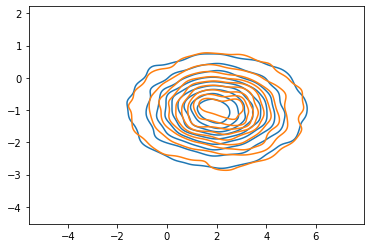

In [7]:
sns.kdeplot(x=x1, y=x2)
sns.kdeplot(x=x1_sample, y=x2_sample)

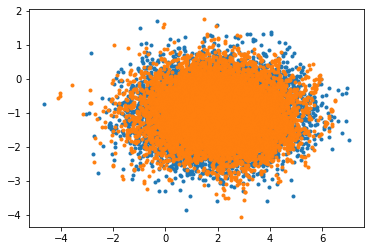

In [8]:
plt.plot(x1, x2, ".")
plt.plot(x1_sample, x2_sample, ".")
plt.show()